Just getting started ...

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

import h5py

#import torch
import torch.nn.functional as F

from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold

from fastai.vision import * 
from fastai import *

import os, shutil
import sys

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
kaggle_path = Path('.') # '.'
kaggle_input_path = Path('/kaggle/input/trends-assessment-prediction') # '/kaggle/input/trends-assessment-prediction'
mri_train_path = Path('/kaggle/input/trends-assessment-prediction/fMRI_train') #fMRI_train


In [3]:
IMPUTATION_STRAT = 'IGNORE_ON_TRAIN' # 'IGNORE_ON_TRAIN', 'MEAN' 
LOSS_BASE = 'MSE' # 'MSE' # 'L1' 'MIX' 'VAR'
LOSS_WEIGHTS = [0.3, 0.175, 0.175, 0.175, 0.175] #[0.2,0.2,0.2,0.2,0.2] #[0,0,0,0,1]#

DEP_VAR = ['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2']

bs=4

TODO:add test to y_data and change dataloader, so it picks img from test and train folder

In [4]:
y_data = pd.read_csv(kaggle_input_path/'train_scores.csv')
y_data = y_data.fillna(0)


In [5]:
f= h5py.File(mri_train_path/'10001.mat','r')
data=f['SM_feature'][()]
data.reshape(1,53,52,63,53).shape 

(1, 53, 52, 63, 53)

In [6]:
class MRIImageList2(ImageList):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    
    def get(self, i):
        fname = self.items[i]
        
        f= h5py.File(fname,'r')
        data=f['SM_feature'][()]
        
        return torch.tensor(data).permute(3,1,0,2).float()


class MRIImageList2_Target(ImageList):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    
    def get(self, i):
        
        y_features = torch.tensor(y_data.iloc[i].values[1:]).float()
        
        fname = self.items[i]
        
        f= h5py.File(fname,'r')
        imgdata=f['SM_feature'][()]
        imgdata=torch.tensor(imgdata).permute(3,1,0,2).float().flatten()
        
        return torch.cat((imgdata, y_features) ,-1)


In [7]:

#https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L414
class MRIImageImageList2(MRIImageList2):
    "`ItemList` suitable for `Image` to `Image` tasks."
    _label_cls, _square_show, _square_show_res = MRIImageList2_Target, False, False

In [8]:

def data():
    return (MRIImageImageList2.from_df(df = y_data, path=kaggle_input_path, cols=['Id'], folder='fMRI_train', suffix='.mat')
          #  .split_none()
        #.split_by_idx(valid_idx=range(200,400))
        .split_by_rand_pct(0.1)    
        #.split_by_files(valid_names = [f'valid_{task}_{i}.png' for i in range(task_info[task]['num_test'])])
        #.label_from_df(cols=DEP_VAR)
        .label_from_func(lambda x: x) #range(10)
        #.transform(get_transforms(), tfm_y=True, size=256, padding_mode = 'border')  #256 #xtra_tfms=[cutout(n_holes=(1,8), length=(16, 16), p=.7)]
        .databunch(bs=bs) #64)
        #.normalize(imagenet_stats)
       )

Loss function combines autoencoder image generating loss and feature loss, if features are the 5 target variables (0 values are ignored, so test data could be included)

In [9]:
class Mixed_Loss(nn.Module):
    def __init__(self, loss_weights = [0.4,0.15,0.15,0.15,0.15], loss_base = 'MSE', bs=64):
        super().__init__()
        
        self.bs=bs
        
        self.loss_base = loss_base
        
        self.loss_weights = loss_weights
        self.fw = Tensor(LOSS_WEIGHTS).cuda()
        self.student_weight = 0.01 # 0.01 #.1
          
            
    def forward(self, input, target,reduction='sum'): #mean
        autoencoder_loss = F.mse_loss(input[:,:-5], target[:,:-5], reduction='mean') * bs #view(self.bs,-1))
        
        #return autoencoder_loss
        
        features = input[:,-5:].T
        target_feat = target[:,-5:]
        
        x0,x1,x2,x3,x4 = features
        
        ## use sign for 0 imputeted empty targets, so they wan't be evaluated
        if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
            sg = target_feat.float().sign()
            x0,x1,x2,x3,x4 = x0.float()*sg[:,0],x1.float()*sg[:,1],x2.float()*sg[:,2],x3.float()*sg[:,3],x4.float()*sg[:,4]
        else: # 'MEAN'
            sg = 1
            x0,x1,x2,x3,x4 = x0.float(),x1.float(),x2.float(),x3.float(),x4.float()
            
        y = target_feat.float()*sg
        
        loss1 = 0
        loss2 = 0
        if self.loss_base in ('MSE','MIX'):
            loss_func = F.mse_loss 
            #reduction = 'sum'
            #loss1 = self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]**2) + \
            #   self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]**2) + \
            #   self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]**2) + \
            #   self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]**2) + \
            #   self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4]**2)
            
            loss1 = (self.fw*(F.mse_loss(features.T*sg,y,reduction='none').sum(dim=0))/((y**2.5).sum(dim=0)))*3
            loss1 = loss1.sum()*self.bs
        
        if self.loss_base in ('L1','MIX'):
            loss_func = F.l1_loss 
            #reduction = 'mean'
            #loss2 =  self.fw[0]*loss_func(x0,y[:,0],reduction=reduction) + \
            #   self.fw[1]*loss_func(x1,y[:,1],reduction=reduction) + \
            #   self.fw[2]*loss_func(x2,y[:,2],reduction=reduction) + \
            #   self.fw[3]*loss_func(x3,y[:,3],reduction=reduction) + \
            #   self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)
            
            reduction = 'sum'
            loss2 =  self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]) + \
               self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]) + \
               self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]) + \
               self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]) + \
               self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4])
            loss2 = loss2*self.bs/4

        return autoencoder_loss/10 + loss1 + loss2 


In [10]:
class AutoEncoderBlock(nn.Module):
    
    def __init__(self, nf):
        super(AutoEncoderBlock, self).__init__()
        
        track_running_stats = True
        affine=True
        
        self.encoder3d = nn.Sequential(
            # since gradients are accum over several batches dont use batchnorm, see
            # https://docs.fast.ai/train.html#AccumulateScheduler
            nn.InstanceNorm3d(53, track_running_stats=track_running_stats, affine=affine),
            nn.Conv3d(nf, 10, 7, stride=(1,2,2), padding =3),
            nn.LeakyReLU(0.1),
            
            nn.Dropout3d(0.1),
            #Lambda(lambda x: x.sin()),
            nn.InstanceNorm3d(10, track_running_stats=track_running_stats, affine=affine),
            nn.Conv3d(10, 1, 5, stride=1, padding = 2),
            
            #Lambda(lambda x: x.sin())
            nn.LeakyReLU(0.1),
            nn.Dropout3d(0.1)
        )
        
        self.encoder2d = nn.Sequential(
            nn.InstanceNorm2d(52, track_running_stats=track_running_stats, affine=affine),
            nn.Conv2d(52, 3, 1, stride=1, padding =0),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.1)
            #Lambda(lambda x: x.sin()),
        )
        
        self.decoder2d = nn.Sequential(
            
            nn.InstanceNorm2d(3, track_running_stats=track_running_stats, affine=affine),
            nn.ConvTranspose2d(3, 52, 1, stride=1, padding = 0),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.1)
        )
        
        self.decoder3d = nn.Sequential(
            
            nn.InstanceNorm3d(1, track_running_stats=track_running_stats, affine=affine),
            nn.ConvTranspose3d(1, 10, 5, stride=1, padding = 2),
            nn.LeakyReLU(0.1),
            nn.Dropout3d(0.1),
            
            nn.InstanceNorm3d(10, track_running_stats=track_running_stats, affine=affine),
            nn.ConvTranspose3d(10, nf, 7, stride=(1,2,2), padding = 3),
            
            nn.Flatten(),
            nn.Hardshrink()
        )
    
    
        self.feature_generator = nn.Sequential(
            nn.Flatten(),
            #nn.InstanceNorm1d(2592, track_running_stats=track_running_stats),
            nn.Linear(2592,8),
            nn.Dropout(0.1),
            #nn.InstanceNorm1d(8, track_running_stats=track_running_stats),
            nn.Linear(8,5),
            SigmoidRange(Tensor([12,12,0,0,0]).cuda(),Tensor([90,90,100,100,100]).cuda())
        )
    
    def forward(self, input):
        x = input #self.c3d_to_2d(input) #[:,:,:,:,10]
       # print(x.shape)
        x = self.encoder3d(x)
       # print(x.shape)
        x = x.view(-1,52, 27, 32)
        x = self.encoder2d(x)
       # print(x.shape)
    
        features = self.feature_generator(x)
        
        x = self.decoder2d(x)
       # print(x.shape)
        x = x.view(-1,1,52, 27, 32)
       # print(x.shape)
        x = self.decoder3d(x)
       # print(x.shape)
        
        return torch.cat((x,features),1)

learner accumulates gradients over n_steps because batch size is small. Backprop happens after bs*n_steps

In [11]:
learn = Learner(data(), AutoEncoderBlock(53), 
                    loss_func = Mixed_Loss(loss_weights = LOSS_WEIGHTS,  
                                             loss_base= LOSS_BASE, bs=bs),
               # loss_func=F.mse_loss,
                        metrics=[mean_absolute_error,mean_squared_error],
                callback_fns=partial(AccumulateScheduler, n_step=16))

learn.clip_grad = 1.0

learn.model_dir = '/kaggle/working'

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,mean_absolute_error,mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


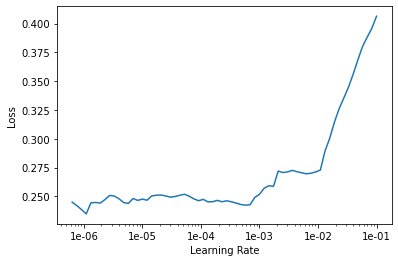

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(3,2e-4)

epoch,train_loss,valid_loss,mean_absolute_error,mean_squared_error,time
0,0.223255,0.219145,0.227157,0.310198,1:13:50
1,0.215359,0.211605,0.222034,0.292173,1:14:01
2,0.206063,0.210447,0.221537,0.289964,1:13:30


In [15]:
learn.model_dir = '/kaggle/working'
learn.export()

OSError: [Errno 30] Read-only file system: '/kaggle/input/trends-assessment-prediction/export.pkl'